In [18]:
# libraries
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

In [2]:
reviews = pd.read_csv("reviews.csv", delimiter="|")
reviewsText = reviews.drop(["Review", "Title"], axis=1)
reviewsText = reviewsText.dropna()
reviewsText

,Content
2,We replace my Cola Zero/Schwibschwab Zero need...
3,A great Isoclear
4,Delicious Isoclear that is simply great to pre...
5,"Delicious, slightly sour taste."
8,"It's okay, but there are better varieties like..."
9,Very good
10,1A
11,Love this! I struggle with normal whey protein...
12,refreshing
15,Fits very well!


In [3]:
def preprocess_text(text):
    # Step 1: Convert to lowercase and tokenize
    tokens = word_tokenize(text.lower())
    
    # Step 2: Remove stopwords
    filtered_tokens = [token for token in tokens if token not in stopwords.words("english")]
    
    # Step 3: Lemmatize each token (FIXED: using 'token' instead of 'tokens')
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Step 4: Join back into a string
    processed_text = " ".join(lemmatized_tokens)
    
    return processed_text

In [4]:
reviewsText["Content"] = reviewsText["Content"].apply(preprocess_text)
reviewsText

,Content
2,replace cola zero/schwibschwab zero need add p...
3,great isoclear
4,delicious isoclear simply great prepare .
5,"delicious , slightly sour taste ."
8,"'s okay , better variety like icy pear ."
9,good
10,1a
11,love ! struggle normal whey protein finding de...
12,refreshing
15,fit well !


In [5]:
# noew let's analyze the sentiment of the words
analyzer = SentimentIntensityAnalyzer()
'''this way we will obtain a dictionary with four keys: neg, neu, pos, and compound'''
# neg = negative sentiment score (between 0 and 1)
# neu = neutral sentiment score (between 0 and 1)
# pos = positive sentiment score (between 0 and 1)
# compound = overall sentiment (between -1 and 1)
def get_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return scores

In [6]:
reviewsText["sentiment"] = reviewsText["Content"].apply(get_sentiment)
reviewsText = pd.concat([
    reviewsText.drop("sentiment", axis=1),
    reviewsText["sentiment"].apply(pd.Series)
], axis = 1)

reviewsText

,Content,neg,neu,pos,compound
2,replace cola zero/schwibschwab zero need add p...,0.000,1.000,0.000,0.0000
3,great isoclear,0.000,0.196,0.804,0.6249
4,delicious isoclear simply great prepare .,0.000,0.278,0.722,0.8316
5,"delicious , slightly sour taste .",0.000,0.448,0.552,0.5719
8,"'s okay , better variety like icy pear .",0.000,0.354,0.646,0.7430
9,good,0.000,0.000,1.000,0.4404
10,1a,0.000,1.000,0.000,0.0000
11,love ! struggle normal whey protein finding de...,0.056,0.319,0.625,0.9726
12,refreshing,0.000,1.000,0.000,0.0000
15,fit well !,0.000,0.000,1.000,0.5983


In [17]:
# Print summary statistics with proper f-strings
print(f"Total reviews: {len(reviewsText)}")
print(f"Positive reviews: {len(reviewsText[reviewsText['compound'] > 0])} ({(len(reviewsText[reviewsText['compound'] > 0])/len(reviewsText)*100):.1f}%)")
print(f"Negative reviews: {len(reviewsText[reviewsText['compound'] < 0])} ({(len(reviewsText[reviewsText['compound'] < 0])/len(reviewsText)*100):.1f}%)")

Total reviews: 14
Positive reviews: 11 (78.6%)
Negative reviews: 0 (0.0%)


In [21]:
# Filter positive/negative reviews
positive_text = " ".join(reviewsText[reviewsText['compound'] > 0]['Content'])
negative_text = " ".join(reviewsText[reviewsText['compound'] < 0]['Content'])

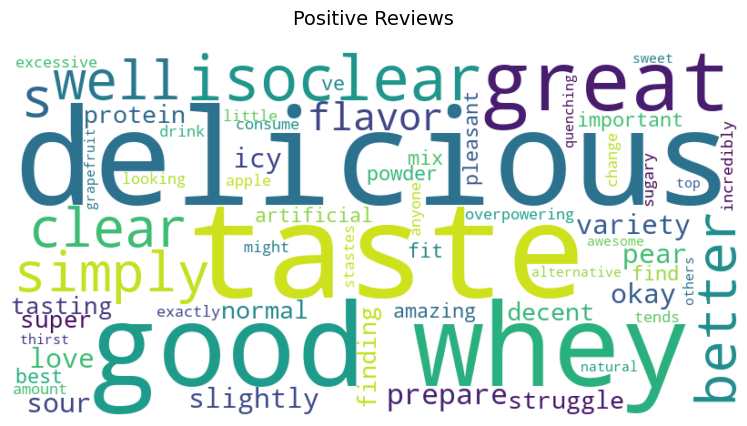

In [22]:
# Generate word clouds
wordcloud_pos = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
# wordcloud_neg = WordCloud(width=800, height=400, background_color='black').generate(negative_text)

# Plot
plt.figure(figsize=(15, 7))

# Positive word cloud
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.title('Positive Reviews', fontsize=14, pad=20)  # Fixed title formatting
plt.axis('off')

# Negative word cloud
# plt.subplot(1, 2, 2)
# plt.imshow(wordcloud_neg, interpolation='bilinear')
# plt.title('Negative Reviews', fontsize=14, pad=20)  # Fixed title formatting
# plt.axis('off')

plt.tight_layout()
plt.show()

In [27]:
# Filter positive/negative reviews
positive_texts = reviewsText[reviewsText['compound'] > 0]['Content'].tolist()
negative_texts = reviewsText[reviewsText['compound'] < 0]['Content'].tolist()

In [28]:
# Combine all documents but mark their class
documents = positive_texts + negative_texts
labels = ['positive'] * len(positive_texts) + ['negative'] * len(negative_texts)

# Compute TF-IDF
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(documents)

# Create a DataFrame of TF-IDF scores
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=vectorizer.get_feature_names_out()
)
tfidf_df['sentiment'] = labels  # Add labels for grouping

In [29]:
# Group by sentiment and get top words
top_words_by_sentiment = {
    sentiment: tfidf_df[tfidf_df['sentiment'] == sentiment]
              .drop(columns='sentiment')
              .mean()
              .nlargest(50)
    for sentiment in ['positive', 'negative']
}

In [31]:
top_words_by_sentiment

{'positive': good            0.137933
 delicious       0.118986
 great           0.104372
 isoclear        0.104372
 simply          0.091376
 fit             0.090909
 taste           0.074056
 better          0.063030
 awesome         0.060000
 flavor          0.056057
 whey            0.051946
 slightly        0.051384
 sour            0.051384
 prepare         0.046902
 icy             0.037976
 like            0.037976
 okay            0.037976
 pear            0.037976
 variety         0.037976
 grapefruit      0.035764
 natural         0.035764
 quenching       0.035764
 sweet           0.035764
 thirst          0.035764
 clear           0.034630
 apple           0.029817
 change          0.029817
 exactly         0.029817
 little          0.029817
 looking         0.029817
 overpowering    0.029817
 pleasant        0.029817
 powder          0.029817
 alternative     0.027507
 consume         0.027507
 drink           0.027507
 excessive       0.027507
 incredibly      0.027507


In [38]:
import pandas as pd

# Convert to DataFrame and print
for sentiment, word_scores in top_words_by_sentiment.items():
    print(f"\n🔠 Top 20 {sentiment.upper()} Words (TF-IDF Scores):")
    print(
        pd.DataFrame(word_scores.nlargest(20),  # Show top 20 words
        columns=['TF-IDF Score']
    ).to_markdown(tablefmt="grid", floatfmt=".3f"))  # Grid format with 3 decimal places


🔠 Top 20 POSITIVE Words (TF-IDF Scores):
+------------+----------------+
|            |   TF-IDF Score |
+============+================+
| good       |          0.138 |
+------------+----------------+
| delicious  |          0.119 |
+------------+----------------+
| great      |          0.104 |
+------------+----------------+
| isoclear   |          0.104 |
+------------+----------------+
| simply     |          0.091 |
+------------+----------------+
| fit        |          0.091 |
+------------+----------------+
| taste      |          0.074 |
+------------+----------------+
| better     |          0.063 |
+------------+----------------+
| awesome    |          0.060 |
+------------+----------------+
| flavor     |          0.056 |
+------------+----------------+
| whey       |          0.052 |
+------------+----------------+
| slightly   |          0.051 |
+------------+----------------+
| sour       |          0.051 |
+------------+----------------+
| prepare    |          0.047 